In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
df = pd.read_csv("Data.csv")

I want to see the trends of units as a whole. For this purpose I will first take a mean for each month, and then plot that. 

C:\Users\haide\AppData\Local\Temp\ipykernel_9016\3710274532.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(monthly_mean.index, rotation=90)
C:\Users\haide\AppData\Local\Temp\ipykernel_9016\3710274532.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(monthly_mean.index, rotation=90)


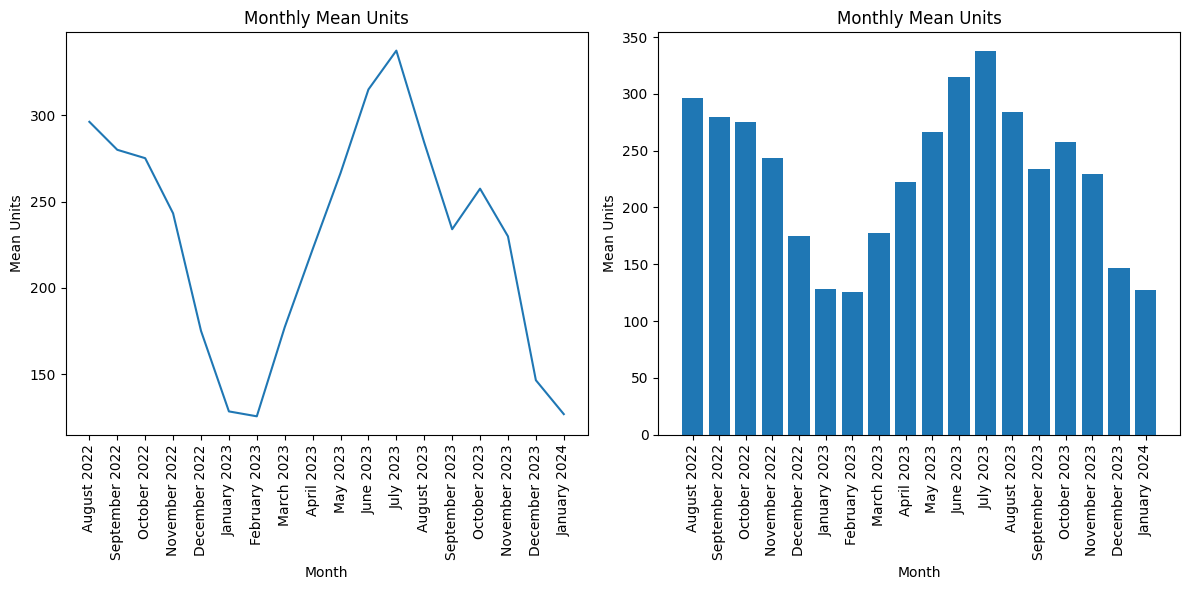

In [16]:
# Calculate monthly mean
monthly_mean = df.drop('Account No', axis=1).mean()

# Plot monthly mean
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Line Graph
axs[0].plot(monthly_mean.index, monthly_mean.values)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Mean Units')
axs[0].set_title('Monthly Mean Units')
axs[0].set_xticklabels(monthly_mean.index, rotation=90)

# Bar Graph
axs[1].bar(monthly_mean.index, monthly_mean.values)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Mean Units')
axs[1].set_title('Monthly Mean Units')
axs[1].set_xticklabels(monthly_mean.index, rotation=90)

plt.tight_layout()
plt.show()

Figure above shows us a very obvious time series trend of units dropping in the winter season and increasing in the summer. This gives us basis to implement the holt-winter exponential smoothing for our dataset. 

1. We do not have 2 complete cycles of data, which means we dont have 2 years of data. 

We are looking for level, trends, and seasonality in our dataset. The code below and the resultant graph shows us the trend and seasonality and we can see that there is clearly a seasonality present. 

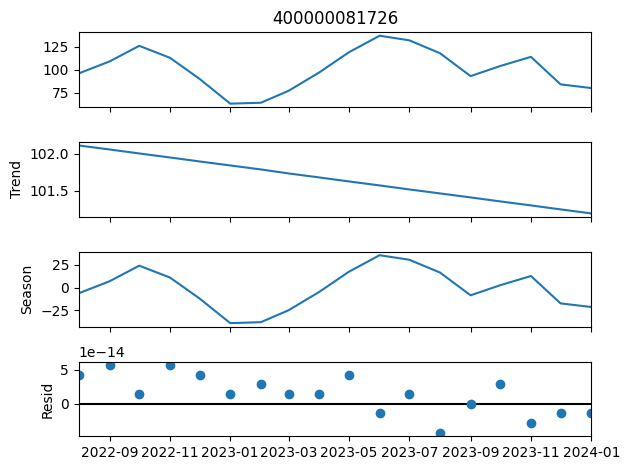

In [17]:
df.set_index('Account No', inplace=True)
df = df.T

# Convert the index to datetime (assuming the columns are months in the format 'Month Year')
df.index = pd.to_datetime(df.index, format='%B %Y')

# Select a single account for analysis (for example, the first account in the DataFrame)
account_data = df.iloc[:, 0]

# Perform STL decomposition
stl = STL(account_data, seasonal=13)  # Adjust the seasonal parameter as needed
result = stl.fit()

result.plot()
plt.show()

In [18]:
df.index.freq = 'MS'
m = 12
alpha = 1 / (2 * m)

In [19]:
forecasts = []

for account in df.columns:
    account_data = df[account]

    # Apply Holt-Winters Exponential Smoothing (Multiplicative)
    model_mul = ExponentialSmoothing(account_data, trend='mul', seasonal='mul', seasonal_periods=6, initialization_method="estimated")
    hw_fit_mul = model_mul.fit()
    
    # Forecast the next month's value
    forecast = hw_fit_mul.forecast(1)
    forecasts.append(forecast.iloc[0])

# Create a new DataFrame for the forecasts
forecast_df = pd.DataFrame({'Account No': df.columns, 'Next Month Forecast': forecasts})
forecast_df.set_index('Account No', inplace=True)

# Transpose the original DataFrame back to the original format
df = df.T

# Append the forecast column to the original DataFrame
df['Next Month Forecast'] = forecast_df['Next Month Forecast']

# Reset index to match the original CSV format
df.reset_index(inplace=True)

# Save the DataFrame with forecasts to a new CSV file
df.to_csv('Data_with_Forecasts.csv', index=False)

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimizatio

MAE: 120.30970314125955, MSE: 23446.691078134863, RMSE: 153.12312391711077


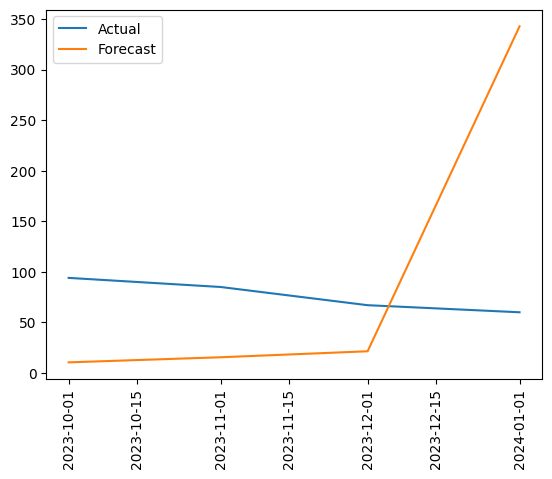

In [20]:
train_data = account_data[:int(0.8*len(account_data))]
test_data = account_data[int(0.8*len(account_data)):]

# Apply Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=6, initialization_method="estimated")
hw_fit = model.fit()

# Forecast
forecast = hw_fit.forecast(len(test_data))

# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

# Plot actual vs forecast
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.tick_params(axis='x', rotation=90)
plt.show()